Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices.

Using two techniques for quantization
1. post training quantization -> tf.lite convert -> quantization
2. quantization aware training -> quantize_function -> fine tuning(training again) -> tf.lite convert

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

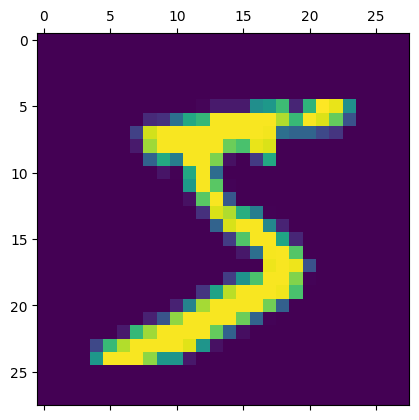

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2709 - accuracy: 0.9223
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1210 - accuracy: 0.9642
Epoch 3/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0859 - accuracy: 0.9744
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0642 - accuracy: 0.9807
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0502 - accuracy: 0.9849


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0770 - accuracy: 0.9748


[0.07702973484992981, 0.9747999906539917]

In [14]:
model.save("saved_models/original_model")

INFO:tensorflow:Assets written to: saved_models/original_model\assets


1. Post Training Quantization -> tf.file covertion and then quantization

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_models/original_model')
tf_lite_model = converter.convert()

In [16]:
len(tf_lite_model)

320004

In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_models/original_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]   #coverted into integers
tf_lite_quant_model = converter.convert()

In [18]:
len(tf_lite_quant_model)

84880

In [33]:
with open("saved_models/tf_lite_model.tflite", "wb") as f:
  f.write(tf_lite_model)

In [34]:
with open("saved_models/tf_lite_quant_model.tflite", "wb") as f:
  f.write(tf_lite_quant_model)

Quantization aware Training -> quantize -> retrain & test-> tf.lite

In [23]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [24]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 9s 4ms/step - loss: 0.0431 - accuracy: 0.9864


In [26]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0759 - accuracy: 0.9777


[0.07588609308004379, 0.9776999950408936]

In [27]:
q_aware_model_lite = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
q_aware_model_lite.optimizations = [tf.lite.Optimize.DEFAULT]
q_aware_model_lite = q_aware_model_lite.convert()

INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpy490y_70\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpy490y_70\assets
c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [35]:
with open("saved_models/q_aware_model_lite.tf_lite", "wb") as f:
    f.write(q_aware_model_lite)

In [31]:
len(q_aware_model_lite)

82736

In [32]:
len(tf_lite_quant_model)

84880